In [1]:
import os
# os.environ['CXX'] = '/usr/bin/g++'
# os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1'

#os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/usr/lib/clang/16/include -I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include -I/Library/Developer/CommandLineTools/usr/include'
os.environ["PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:" + os.environ["PATH"]
os.environ["PKG_CONFIG_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/pkgconfig:" + os.environ.get("PKG_CONFIG_PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

# Verify if paths are set correctly
print("PATH:", os.environ["PATH"])
print("PKG_CONFIG_PATH:", os.environ["PKG_CONFIG_PATH"])
print("LD_LIBRARY_PATH:", os.environ["LD_LIBRARY_PATH"])


PATH: /Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/bin:/Users/deepprakashravi/miniforge3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/TeX/texbin:/usr/local/share/dotnet:~/.dotnet/tools:/usr/local/munki:/usr/local/munkireport:/Users/deepprakashravi/Library/Application Support/JetBrains/Toolbox/scripts:/Users/deepprakashravi/.local/bin:/Users/deepprakashravi/.local/bin:/Users/deepprakashravi/miniforge3/bin:/Users/deepprakashravi/miniforge3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cry

In [2]:
from __future__ import absolute_import, division, print_function

from dolfin import *

import math
import numpy as np
import logging

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import nb

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)

/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:79: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:79: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
    

dim(Vh) =  4096


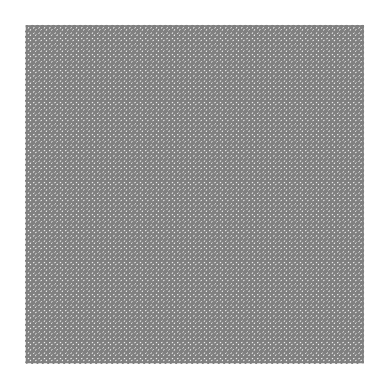

In [3]:
n = 63
degree = 1
mesh = UnitSquareMesh(n, n)
nb.plot(mesh)

Vh  = FunctionSpace(mesh, 'Lagrange', degree)
print( "dim(Vh) = ", Vh.dim() )

In [4]:
mesh_nodes = mesh.coordinates()
print(mesh_nodes)
np.save("nodes.npy", mesh_nodes)


[[0.         0.        ]
 [0.01587302 0.        ]
 [0.03174603 0.        ]
 ...
 [0.96825397 1.        ]
 [0.98412698 1.        ]
 [1.         1.        ]]


In [5]:
class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] - 1) < DOLFIN_EPS

class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]) < DOLFIN_EPS

class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < DOLFIN_EPS

class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < DOLFIN_EPS

boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#boundary_parts = FacetFunction("size_t", mesh)
boundary_parts.set_all(0)

Gamma_top = TopBoundary()
Gamma_top.mark(boundary_parts, 1)
Gamma_bottom = BottomBoundary()
Gamma_bottom.mark(boundary_parts, 2)
Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 3)
Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 4)



In [6]:
u_L = Constant(0.)
u_R = Constant(3.)

sigma_bottom = Expression('-(pi/2.0)*sin(2*pi*x[0])', degree=5)
sigma_top    = Constant(0.)

f = Expression('(4.0*pi*pi+pi*pi/4.0)*(sin(2*pi*x[0])*sin((pi/2.0)*x[1]))', degree=5)

bcs = [DirichletBC(Vh, u_L, boundary_parts, 3),
       DirichletBC(Vh, u_R, boundary_parts, 4)]

ds = Measure("ds", subdomain_data=boundary_parts)

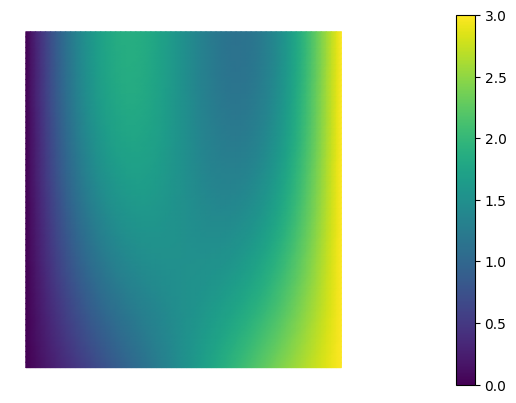

In [7]:
u = TrialFunction(Vh)
v = TestFunction(Vh)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx + sigma_top*v*ds(1) + sigma_bottom*v*ds(2)

uh = Function(Vh)

#solve(a == L, uh, bcs=bcs)
A, b = assemble_system(a,L, bcs=bcs)
solve(A, uh.vector(), b, "cg")

nb.plot(uh)

In [8]:
u_e = Expression('sin(2*pi*x[0])*sin((pi/2.0)*x[1])', degree=5)
grad_u_e = Expression( ('2*pi*cos(2*pi*x[0])*sin((pi/2.0)*x[1])', 'pi/2.0*sin(2*pi*x[0])*cos((pi/2.0)*x[1])'), degree=5)

err_L2 = sqrt( assemble( (uh-u_e)**2*dx ) )
err_grad = sqrt( assemble( inner(nabla_grad(uh) - grad_u_e, nabla_grad(uh) - grad_u_e)*dx ) )
err_H1 = sqrt( err_L2**2 + err_grad**2)

print ("|| u_h - u_e ||_L2 = ", err_L2)
print ("|| u_h - u_e ||_H1 = ", err_H1)

|| u_h - u_e ||_L2 =  1.7321960002087657
|| u_h - u_e ||_H1 =  3.465653957087922


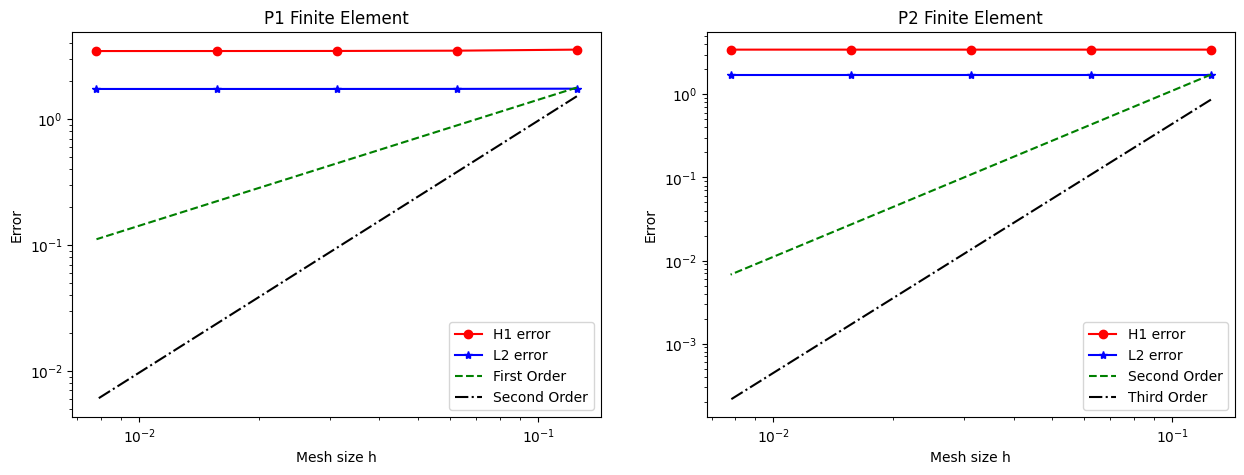

In [9]:
def compute(n, degree):
    mesh = UnitSquareMesh(n, n)
    Vh  = FunctionSpace(mesh, 'Lagrange', degree)
    
    boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    boundary_parts.set_all(0)

    Gamma_top = TopBoundary()
    Gamma_top.mark(boundary_parts, 1)
    Gamma_bottom = BottomBoundary()
    Gamma_bottom.mark(boundary_parts, 2)
    Gamma_left = LeftBoundary()
    Gamma_left.mark(boundary_parts, 3)
    Gamma_right = RightBoundary()
    Gamma_right.mark(boundary_parts, 4)

    bcs = [DirichletBC(Vh, u_L, boundary_parts, 3), DirichletBC(Vh, u_R, boundary_parts, 4)]
    ds = Measure("ds", subdomain_data=boundary_parts)

    u = TrialFunction(Vh)
    v = TestFunction(Vh)
    a = inner(nabla_grad(u), nabla_grad(v))*dx
    L = f*v*dx + sigma_top*v*ds(1) + sigma_bottom*v*ds(2)
    uh = Function(Vh)
    solve(a == L, uh, bcs=bcs)
    err_L2 = sqrt( assemble( (uh-u_e)**2*dx ) )
    err_grad = sqrt( assemble( inner(nabla_grad(uh) - grad_u_e, nabla_grad(uh) - grad_u_e)*dx ) )
    err_H1 = sqrt( err_L2**2 + err_grad**2)

    return err_L2, err_H1

nref = 5
n = 8*np.power(2,np.arange(0,nref))
h = 1./n

err_L2_P1 = np.zeros(nref)
err_H1_P1 = np.zeros(nref)
err_L2_P2 = np.zeros(nref)
err_H1_P2 = np.zeros(nref)

for i in range(nref):
    err_L2_P1[i], err_H1_P1[i] = compute(n[i], 1)
    err_L2_P2[i], err_H1_P2[i] = compute(n[i], 2)

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.loglog(h, err_H1_P1, '-or', label = "H1 error")
plt.loglog(h, err_L2_P1, '-*b', label = "L2 error")
plt.loglog(h, h*.5*err_H1_P1[0]/h[0], '--g', label = "First Order")
plt.loglog(h, np.power(h,2)*.5*np.power( err_L2_P1[0]/h[0], 2), '-.k', label = "Second Order")
plt.xlabel("Mesh size h")
plt.ylabel("Error")
plt.title("P1 Finite Element")
plt.legend(loc='lower right')


plt.subplot(122)
plt.loglog(h, err_H1_P2, '-or', label = "H1 error")
plt.loglog(h, err_L2_P2, '-*b', label = "L2 error")
plt.loglog(h, np.power(h/h[0],2)*.5*err_H1_P2[0], '--g', label = "Second Order")
plt.loglog(h, np.power(h/h[0],3)*.5*err_L2_P2[0], '-.k', label = "Third Order")
plt.xlabel("Mesh size h")
plt.ylabel("Error")
plt.title("P2 Finite Element")
plt.legend(loc='lower right')

plt.show()